In [38]:
"""
尝试谱归一化以及减小置信度（简单来说，把那个标签做的小一点，1-->0.8，0-->0.1这样类似得操作）
"""

'\n尝试谱归一化以及减小置信度（简单来说，把那个标签做的小一点，1-->0.8，0-->0.1这样类似得操作）\n'

In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from patch_based_se import *
criterion_MSE = nn.MSELoss()
criterion_L1 = nn.L1Loss()

In [40]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset_path_A = "../datasets/horse2zebra/trainA"
dataset_path_B = "../datasets/horse2zebra/trainB"

train_set_A = ImageFolder(root=dataset_path_A, transform=transform)
train_loader_A = DataLoader(train_set_A, batch_size=20, shuffle=True)
train_set_B = ImageFolder(root=dataset_path_B, transform=transform)
train_loader_B = DataLoader(train_set_B, batch_size=20, shuffle=True)

test_set_A = ImageFolder(root="../datasets/horse2zebra/testA", transform=transform)
test_loader_A = DataLoader(test_set_A, batch_size=8, shuffle=True)

In [41]:
print(len(train_set_A), len(train_set_B))
print(len(train_loader_A), len(train_loader_B))
print(train_set_A[0][0].size())

1067 1334
54 67
torch.Size([3, 128, 128])


In [42]:
def adversarial_loss(d_real, d_fake,is_generator:bool):
    #这里的设计主要是为了让这个网络不要那么武断
    fake_labels = torch.full(d_fake.size(),0.1).cuda()
    if is_generator:
        real_labels = torch.full(d_fake.size(),0.8).cuda()
        return criterion_MSE(d_fake, real_labels)
    else:
        real_labels = torch.full(d_real.size(),0.8).cuda()
        return criterion_MSE(d_real, real_labels)+ criterion_MSE(d_fake, fake_labels)

def cycle_consistency_loss(x,y,reconstructed_x,reconstructed_y):
    l_x = criterion_L1(reconstructed_x,x)
    l_y = criterion_L1(reconstructed_y,y)
    return l_x + l_y

def total_loss(x,y,reconstructed_x,reconstructed_y,dgx,dfy,dx,dy,is_generator:bool):
    cyc_loss = cycle_consistency_loss(x,y,reconstructed_x,reconstructed_y)
    l_x2y = adversarial_loss(dy,dgx,is_generator)
    l_y2x = adversarial_loss(dx,dfy,is_generator)
    return cyc_loss + l_x2y + l_y2x

In [43]:
class ResnetBlock(nn.Module):
    def __init__(self,dim):
        super(ResnetBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=dim,out_channels=dim,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=dim,out_channels=dim,kernel_size=3,stride=1,padding=1)
        self.norm1 = nn.InstanceNorm2d(dim,affine=True)
        self.norm2 = nn.InstanceNorm2d(dim,affine=True)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = x + out
        out = self.relu(out)
        return out

class Up(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1)
        self.norm1 = nn.InstanceNorm2d(128,affine=True)
        #self.pse1 =PSE(128,16,16)  #这里的小块是4*4的

        self.relu = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1)
        #self.pse2 = PSE(64,16,16)   #这里的小块8*8
        self.norm2 = nn.InstanceNorm2d(64,affine=True)

        self.conv3 = nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=8,stride=2,padding=3)
        self.pse3 = PSE(3,32,16) #16*16
        self.norm3 = nn.InstanceNorm2d(3,affine=True)
        self.tanh = nn.Tanh()

    def forward(self,x):
        out = self.conv1(x)
        #out = self.pse1(out)
        out = self.norm1(out)
        out = self.relu(out)


        out = self.conv2(out)
        #out = self.pse2(out)
        out = self.norm2(out)
        out = self.relu(out)


        out = self.conv3(out)
        out = self.pse3(out)
        out = self.norm3(out)
        out = self.tanh(out)
        return out

In [44]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=8,stride=2,padding=3),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.InstanceNorm2d(128,affine=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.InstanceNorm2d(256,affine=True),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
        )

        self.block3 = Up()

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)

        return out

In [45]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_channels=3, num_filters=64):
        super(PatchGANDiscriminator, self).__init__()

        # 输入层: 图像经过若干卷积层后输出一个局部判断
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, num_filters, kernel_size=4, stride=2, padding=1),  # 输出 [batch_size, 64, H/2, W/2]
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_filters, num_filters * 2, kernel_size=4, stride=2, padding=1),  # 输出 [batch_size, 128, H/4, W/4]
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=4, stride=2, padding=1),  # 输出 [batch_size, 256, H/8, W/8]
            nn.BatchNorm2d(num_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_filters * 4, num_filters * 8, kernel_size=4, stride=2, padding=1),  # 输出 [batch_size, 512, H/16, W/16]
            nn.BatchNorm2d(num_filters * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_filters * 8, 1, kernel_size=4, stride=1, padding=1),  # 输出 [batch_size, 1, H/16, W/16]
            nn.Sigmoid()  # 输出每个patch的真实性（0或1）
        )

    def forward(self, x):
        return self.model(x)

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator_x2y = Generator().to(device)
discriminator_y = PatchGANDiscriminator().to(device)
generator_y2x = Generator().to(device)
discriminator_x = PatchGANDiscriminator().to(device)

generator_x2y.load_state_dict(torch.load("generator_x2y.pth"),strict=False)
generator_y2x.load_state_dict(torch.load("generator_y2x.pth"),strict=False)
discriminator_x.load_state_dict(torch.load("discriminator_x.pth"),strict=False)
discriminator_y.load_state_dict(torch.load("discriminator_y.pth"),strict=False)

C:\Users\LiuJiTing\AppData\Local\Temp\ipykernel_14388\987806952.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_x2y.load_state_dict(torch.load("generator_x2y.p

<All keys matched successfully>

In [47]:
from torch.optim import Adam
g_x2y_optimizer = Adam(generator_x2y.parameters(), lr=0.0001, betas=(0.5, 0.999))
g_y2x_optimizer = Adam(generator_y2x.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_y_optimizer = Adam(discriminator_y.parameters(), lr=0.0004, betas=(0.5, 0.999))
d_x_optimizer = Adam(discriminator_x.parameters(), lr=0.0004, betas=(0.5, 0.999))

In [48]:
d_losses = []
g_losses = []

def train(epochs):
    for epoch in range(epochs):
        g_running_loss = 0.0
        d_running_loss = 0.0
        length = max(len(train_loader_A), len(train_loader_B))  # 取较长的长度

        # 创建迭代器
        iter_A = iter(train_loader_A)
        iter_B = iter(train_loader_B)

        for i in range(length):
            try:
                x = next(iter_A)[0].to(device)
            except StopIteration:
                iter_A = iter(train_loader_A)  # 重新开始
                x = next(iter_A)[0].to(device)

            try:
                y = next(iter_B)[0].to(device)
            except StopIteration:
                iter_B = iter(train_loader_B)  # 重新开始
                y = next(iter_B)[0].to(device)

            # --------------------------
            # 1. 训练鉴别器 D_X 和 D_Y
            # --------------------------
            d_x_optimizer.zero_grad()
            d_y_optimizer.zero_grad()

            fake_y = generator_x2y(x).detach()
            fake_x = generator_y2x(y).detach()

            d_real_x = discriminator_x(x)
            d_fake_x = discriminator_x(fake_x)
            d_real_y = discriminator_y(y)
            d_fake_y = discriminator_y(fake_y)

            loss_d_x = adversarial_loss(d_real_x, d_fake_x, is_generator=False)
            loss_d_y = adversarial_loss(d_real_y, d_fake_y, is_generator=False)
            d_loss = loss_d_x + loss_d_y

            d_loss.backward()
            d_running_loss += d_loss.item()
            d_x_optimizer.step()
            d_y_optimizer.step()

            # --------------------------
            # 2. 训练生成器 G 和 F
            # --------------------------
            g_x2y_optimizer.zero_grad()
            g_y2x_optimizer.zero_grad()

            fake_y = generator_x2y(x)
            fake_x = generator_y2x(y)

            reconstructed_x = generator_y2x(fake_y)
            reconstructed_y = generator_x2y(fake_x)
            cycle_loss = cycle_consistency_loss(x, y, reconstructed_x, reconstructed_y)

            d_fake_y = discriminator_y(fake_y)
            d_fake_x = discriminator_x(fake_x)
            loss_g_y = adversarial_loss(None, d_fake_y, is_generator=True)
            loss_g_x = adversarial_loss(None, d_fake_x, is_generator=True)

            g_loss = 10*cycle_loss + loss_g_y + loss_g_x

            g_loss.backward()
            g_running_loss += g_loss.item()
            g_x2y_optimizer.step()
            g_y2x_optimizer.step()

            if (i + 1) % 10 == 0:
                print(
                    f"Epoch : [{epoch + 1}/{epochs}]\tIter : [{i + 1}/{length}]\t"
                    f"Generator Loss: {g_running_loss / (i + 1):.3f}\t"
                    f"Discriminator Loss: {d_running_loss / (i + 1):.3f}",
                    '\n'
                )

        d_losses.append(d_running_loss / length)
        g_losses.append(g_running_loss / length)
        print(
            f"Epoch : [{epoch + 1}/{epochs}]\t"
            f"Generator Loss: {g_running_loss / length:.3f}\t"
            f"Discriminator Loss: {d_running_loss / length:.3f}"
        )

def draw(epochs):
    epochs = list(range(epochs))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1行2列的子图

    # 绘制 Generator Loss
    axes[0].plot(epochs, g_losses, marker='o', color='blue', label='Generator Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('G Loss')
    axes[0].set_title('Generator Loss Curve')
    axes[0].legend()

    # 绘制 Discriminator Loss
    axes[1].plot(epochs, d_losses, marker='s', color='red', label='Discriminator Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('D Loss')
    axes[1].set_title('Discriminator Loss Curve')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [49]:
if __name__ == '__main__':
    train(10)
    draw(10)

Epoch : [1/10]	Iter : [10/67]	Generator Loss: 5.548	Discriminator Loss: 0.175 

Epoch : [1/10]	Iter : [20/67]	Generator Loss: 5.490	Discriminator Loss: 0.136 

Epoch : [1/10]	Iter : [30/67]	Generator Loss: 5.433	Discriminator Loss: 0.155 

Epoch : [1/10]	Iter : [40/67]	Generator Loss: 5.400	Discriminator Loss: 0.146 

Epoch : [1/10]	Iter : [50/67]	Generator Loss: 5.389	Discriminator Loss: 0.140 

Epoch : [1/10]	Iter : [60/67]	Generator Loss: 5.360	Discriminator Loss: 0.180 

Epoch : [1/10]	Generator Loss: 5.341	Discriminator Loss: 0.181
Epoch : [2/10]	Iter : [10/67]	Generator Loss: 5.189	Discriminator Loss: 0.242 

Epoch : [2/10]	Iter : [20/67]	Generator Loss: 5.221	Discriminator Loss: 0.156 

Epoch : [2/10]	Iter : [30/67]	Generator Loss: 5.221	Discriminator Loss: 0.140 

Epoch : [2/10]	Iter : [40/67]	Generator Loss: 5.243	Discriminator Loss: 0.121 

Epoch : [2/10]	Iter : [50/67]	Generator Loss: 5.235	Discriminator Loss: 0.109 

Epoch : [2/10]	Iter : [60/67]	Generator Loss: 5.250	Discr

KeyboardInterrupt: 

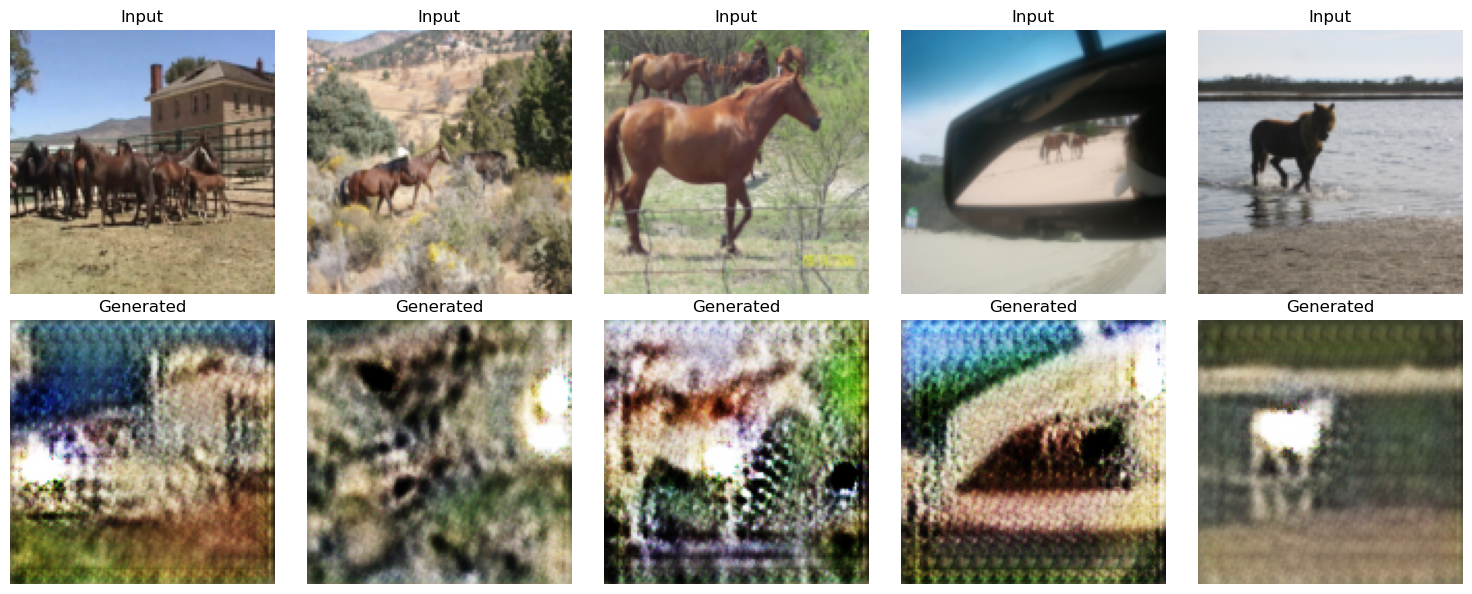

In [50]:
def visualize_results(generator, test_loader, device, num_images=5):
    # 设置模型为评估模式
    generator.eval()

    # 从测试集中加载一些样本
    images = next(iter(test_loader))[0][:num_images].to(device)

    # 生成目标域图像
    with torch.no_grad():
        generated_images = generator(images)

    # 将输入图像和生成图像并排显示
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # 显示输入图像
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)  # 反归一化
        plt.title("Input")
        plt.axis("off")

        # 显示生成图像
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)  # 反归一化
        plt.title("Generated")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 调用函数
visualize_results(generator_x2y, test_loader_A, device)

In [37]:
torch.save(generator_x2y.state_dict(), "generator_x2y.pth")
torch.save(generator_y2x.state_dict(),"/generator_y2x.pth")
torch.save(discriminator_x.state_dict(), "discriminator_x.pth")
torch.save(discriminator_y.state_dict(), "discriminator_y.pth")